In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
from sklearn import svm
import os
import requests

In [79]:
def make_frame(content):
    prices = {}
    for line in content.split('\n'):
        if '{' in line or '}' in line:
            continue
        data = (
            line
            .lstrip().lstrip("'")
            .rstrip().rstrip("',")
            .split(':')
        )
        if len(data) < 3:
            data.append(np.nan)
        secs, price, volume = data
        prices[int(secs)] = (int(price), float(volume))
        
    price_frame = pd.DataFrame(prices, index = ['price', 'volume']).T
    price_frame.index = pd.to_datetime(price_frame.index, unit = 's')
    
    return price_frame

def fetch_from_wiki(item_name):
    # Totally lifted from:
    # https://github.com/osrsbox/osrsbox.github.io/blob/master/_posts/2018-12-14-scraping-the-osrs-wiki-part3.md
    
    # Construction custom user-agent for query
    custom_agent = {
        'User-Agent': 'CSCE421Scraper',
        'From': 'presley.graham@tamu.edu' 
    }
    
    page_title = f'Module:Exchange/{item_name}/Data'

    # Construct the para.meters of the API query
    parameters = {
        'action': 'parse',
        'prop': 'wikitext',
        'format': 'json',
        'page': page_title,
    }

    # Call the API using the custom user-agent and parameters
    result = requests.get('https://oldschool.runescape.wiki/api.php', 
                            headers=custom_agent, 
                            params=parameters).json()
    
    content = result['parse']['wikitext']['*']
    return make_frame(content)

In [80]:
def item_filename(item_name):
    return os.path.join('data', f'{item_name}.csv')

def fetch_from_disk(item_name):
    file_name = item_filename(item_name)
    
    # First, check to make sure the item is actually on disk
    if not os.path.isfile(file_name):
        return None
    
    # Read in the price frame; manually set index to first line
    price_frame = pd.read_csv(file_name).set_index('Unnamed: 0')
    
    display(price_frame)
    
    # Get rid of the ugly index name
    price_frame.index.name = None
    
    return price_frame

In [81]:
from functools import lru_cache

# fetch(item_name) returns 
@lru_cache(maxsize = None)
def fetch(item_name):
    # check if we have the item data on disk
    # TODO: check if the data is too old
    price_frame = None #fetch_from_disk(item_name)
    if price_frame is not None:
        return price_frame
    
    # if not, fetch it from the wiki
    price_frame = fetch_from_wiki(item_name)
    # and dump it to a file
    price_frame.to_csv(item_filename(item_name))
    return price_frame

def prices(item_name):
    price = fetch(item_name)['price'].dropna()
    return price

def limit_to_dates(series, start_on = '1980-01-01', end_before = '3000-01-01'):
    start_date = pd.to_datetime(start_on)
    end_date = pd.to_datetime(end_before)
    return series[(start_date <= series.index) & (series.index < end_date)]

In [237]:
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

def double_plot(dList):
    fig, axs = plt.subplots(figsize=(15, 10))
    
    for (lst,label) in dList:
        axs.plot(lst.index,list(lst), label = label)
    
    fig.text(0.5, 0.04, 'date', ha='center', va='center')
    fig.text(0.06, 0.5, 'returns', ha='center', va='center', rotation='vertical')

    


    axs.legend()
    plt.show()

212
212
212


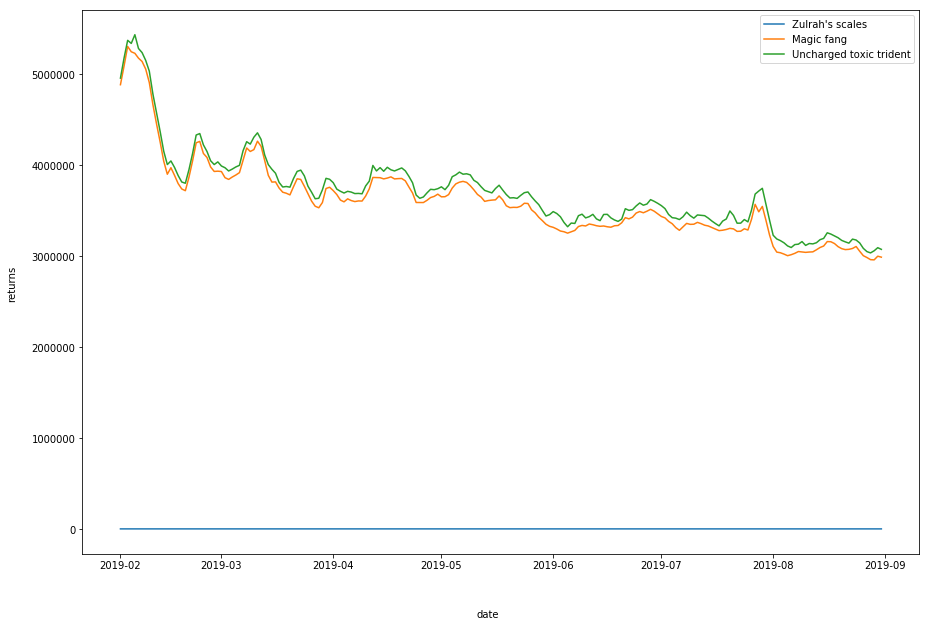

In [256]:
# half way point, any coorilation should be visible at this stage

itemList = []
itemList.append("Zulrah's scales")
itemList.append("Magic fang")
itemList.append("Uncharged toxic trident")


rItem = "Uncharged toxic trident"
shift = 3
train_test_split_ratio = 5

resultant = (limit_to_dates(prices(rItem), '2019-02-04', '2019-9-04'),rItem)
dList = []
for item in itemList:
    dList.append((limit_to_dates(prices(item), '2019-02-01', '2019-9-01'),item))
    print(len((limit_to_dates(prices(item), '2019-02-01', '2019-9-01'))))



double_plot(dList)





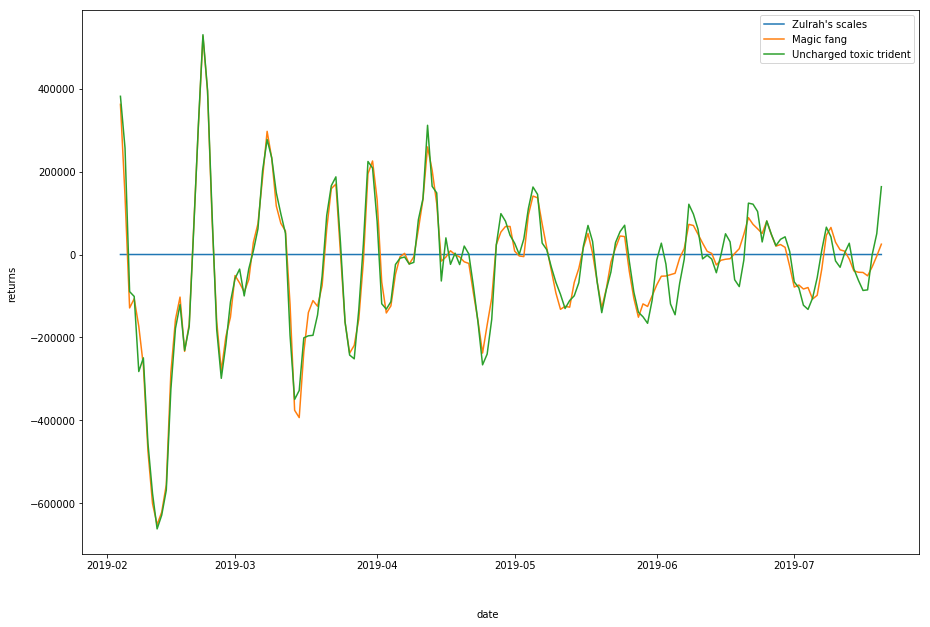

SVR(C=100000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1e-08,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [278]:
#calculating profit and creating labels based on them


length = len(dList[0][0])

trainList = []
testList = []
for (data,label) in dList:
    trainList.append((data[:length-int(length/train_test_split_ratio)],label))
    testList.append((data[length-int(length/train_test_split_ratio):],label))
trainResultant = (resultant[0][:length-int(length/train_test_split_ratio)],resultant[1])
testResultant = (resultant[0][length-int(length/train_test_split_ratio):],resultant[1])


profitList = []
profitTest = []
for (data,label) in trainList:
    profitList.append(((data - data.shift(shift)).dropna(),label))
for (data,label) in testList:
    profitTest.append(((data - data.shift(shift)).dropna(),label))
profitResultant = ((trainResultant[0] - trainResultant[0].shift(shift)).dropna(),trainResultant[1])
testProfitResultant = ((testResultant[0] - testResultant[0].shift(shift)).dropna(),testResultant[1])
   
    
double_plot(profitList)


X = [[] for i in profitList[0][0]]
for (data,label) in profitList:
    for i in range(len(data)):
        X[i].append(data[i])
        
y = []
for val in profitResultant[0]:
    y.append(val)


clf = svm.SVR(C=100000,gamma = 1e-8)
clf.fit(X,y)





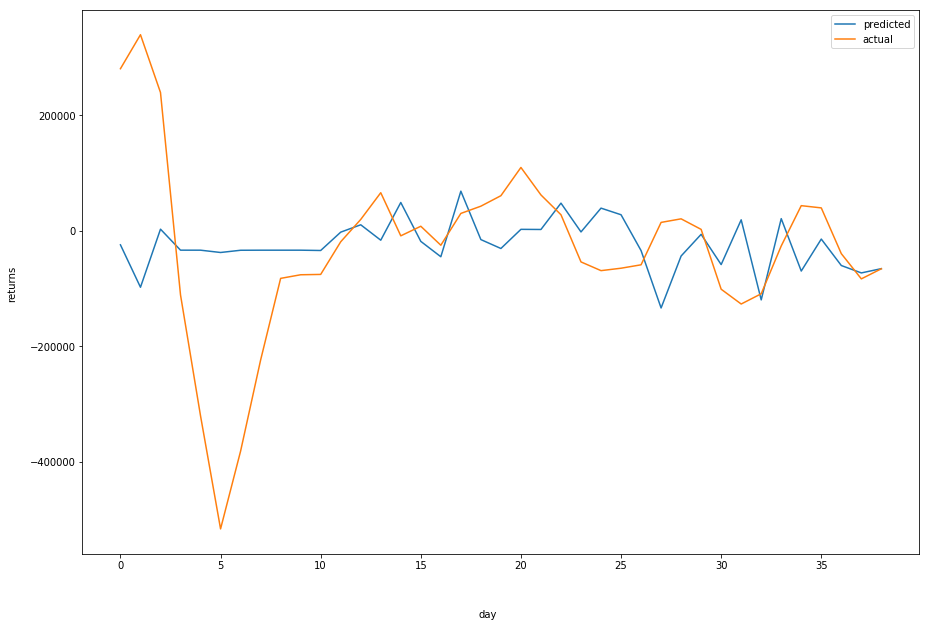

In [280]:
predictor = [[] for i in profitTest[0][0]]
for (data,label) in profitTest:
    for i in range(len(data)):
        predictor[i].append(data[i])

predicted = clf.predict(predictor)

fig, axs = plt.subplots(figsize=(15, 10))

x = range(len(predicted))

axs.plot(x,list(predicted), label = 'predicted')
axs.plot(x,list(testProfitResultant[0]), label = 'actual')
# axs.fill_between(x, testProfitResultant[0],predicted, where=abs(predicted-testProfitResultant[0]) <1000,
#                  facecolor='green', interpolate=True)
fig.text(0.5, 0.04, 'day', ha='center', va='center')
fig.text(0.06, 0.5, 'returns', ha='center', va='center', rotation='vertical')


axs.legend()
plt.show()